In [1121]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
from scipy.linalg import solve_sylvester, norm
import os
from sklearn.metrics import confusion_matrix, f1_score
import json
import pandas as pd

Data generation

In [1122]:
def ensure_positive_definite(M, epsilon=1e-1, min_threshold=1e-3):
    """Ensure M is well-conditioned ; add small value to diagonal if needed"""
    min_eig = np.min(np.linalg.eigvals(M))
    
    if min_eig < min_threshold:
        print(f"Minimum eigenvalue too small ({min_eig:.2e}), adding {epsilon} to diagonal elements.")
        M += np.eye(M.shape[0]) * (abs(min_eig) + epsilon)
    
    return M

In [1123]:
def make_tridiagonal_spd_matrix(
        n_dim=10,
        smallest_coef=0.1,
        largest_coef=0.9,
        random_state=None
):
    """ 
    Generate a tridiagonal SPD matrix
    """

    rng = np.random.default_rng(random_state)
    diag = [1 for _ in range(n_dim)]
    sub_diag = [rng.uniform(low=smallest_coef, high= largest_coef) for _ in range(n_dim-1)]
    # sub_diag = [0.7 for _ in range(n_dim-1)]

    m = np.zeros((n_dim, n_dim), dtype= float)

    # fill diagonal values
    for i in range(n_dim):
        m[i][i] = diag[i]

    # fill sub, sup diagonal values, they are same here to be symmetric
    for i in range(n_dim-1):
        m[i+1][i] = sub_diag[i] 
        m[i][i+1] = sub_diag[i]
    

    return ensure_positive_definite(m)
    

Minimum eigenvalue too small (-1.74e-01), adding 0.1 to diagonal elements.


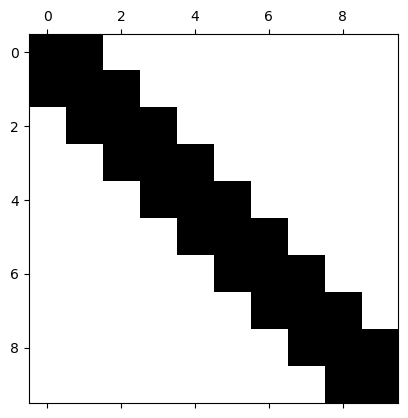

In [1124]:
plt.spy(make_tridiagonal_spd_matrix()) # check if its giving 

In [1125]:
def generate_sparse_covariance(B, sample_scaling=1.0):
    """
    Generate a sparse inverse covariance matrix B, compute its associated covariance matrix E,
    and generate samples from a multivariate normal distribution with covariance E.

    Parameters:
    - n (int): Dimension of the matrix.
    - sample_scaling (float): Scaling factor for the number of samples (N = sample_scaling * d^2 log2(n)).
    - random_state (int): Random seed for reproducibility.

    Returns:
    - S (np.ndarray): Sample covariance matrix from the generated samples.
    - N (int): Computed number of samples.
    """
    # np.random.seed(random_state)

    # Create sparse PSD matrix (B)
    # B = make_tridiagonal_spd_matrix(n_dim=n, random_state= random_state)
    n = len(B)

    # Compute degree d as the maximum number of nonzero entries per row in B (excluding diagonal)
    d = np.max(np.sum(B != 0, axis=1)) - 1  # Exclude diagonal elements
    print("Max degree in B", d)

    # Compute the required number of samples with log 
    N = int(sample_scaling * ((d*d) * np.log(n)))
    # N = max(N, n)  # Ensure N is at least n for stability

    # Compute true inverse covariance matrix (Strue)
    Strue = np.linalg.matrix_power(B, 2)

    # Compute covariance matrix (E)
    E = np.linalg.inv(Strue)

    # Generate N samples Y ~ N(0, E)
    y_samples = la.sqrtm(E).dot(np.random.randn(n, N))

    # Calculate sample covariance matrix
    S = np.cov(y_samples)

    return S, N

Minimum eigenvalue too small (-1.75e-01), adding 0.1 to diagonal elements.
Max degree in B 2
Number of samples 9
F1 norm 59.64611322150112


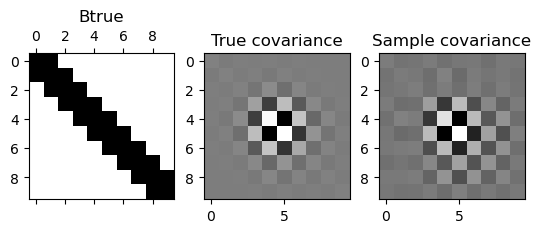

In [1126]:
B = make_tridiagonal_spd_matrix()
S, N = generate_sparse_covariance(B)
plt.subplot(1,3, 1)
plt.spy(B)
plt.title("Btrue")
plt.subplot(1,3,2)
plt.imshow(np.linalg.inv(B@B), cmap = 'gray')
plt.title("True covariance")
plt.subplot(1,3,3)
plt.imshow(S, cmap = 'gray')
plt.title("Sample covariance")
print("Number of samples", N)
print("F1 norm", np.linalg.norm(np.linalg.inv(B@B)-S, ord="fro"))

Algorithm

In [1127]:
def newton_nare(A, B, C, D, X0, tol=1e-13, kmax=30):
    """
    Newton's method for solving the Nonlinear Algebraic Riccati Equation (NARE):
    C + XA + DX - XBX = 0
    """
    X = X0.copy()
    k = 0
    err = 1

    while err > tol and k < kmax:
        # Compute residual RX = C + XA + DX - XBX
        RX = C + X @ A + D @ X - X @ B @ X

        # Solve the Sylvester equation (D - XB)H + H(A - BX) = -RX for H
        H = solve_sylvester(D - X @ B, A - B @ X, -RX)

        # Update X
        X = X + H

        # Calculate the error; changed from l1 to frobenius
        err = norm(H, 1) / norm(X, 1)
        # err = norm(H, 'fro') / (1 + norm(X, 'fro'))

        # Increment iteration counter
        k += 1

    if k % 5 == 0:  # Print every 5 iterations
        print(f"Iteration {k}, Error: {err:.2e}")

    # Check if the solution converged
    if k == kmax:
        print("Warning: reached the maximum number of iterations without convergence.")

    return X

In [1128]:
# Soft thresholding function
def soft_thresholding(x, threshold):
    """Applies soft-thresholding elementwise."""
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

In [1129]:
# ADMM Algorithm for Elastic-Net Penalized Precision Matrix Estimation
def admm_precision_matrix(S, lambda_, rho=1.0, max_iter=100, tol=1e-4):
    """
    ADMM algorithm for precision matrix estimation with elastic-net penalty.
    """
    n = S.shape[0]
    Z = np.zeros((n, n))
    Lambda = np.zeros((n, n))
    I = np.eye(n)  # Identity matrix

    # Initial B (can be initialized as identity matrix)
    B = np.eye(n)

    for k in range(max_iter):
        # Step 1: Update B using Newton NARE
        # Here, we set up the matrices to solve the NARE: A3 + XA1 + A4X - XA2X = 0
        A3 = - 2 * I
        A4 = Lambda - rho * Z
        A1 = 0 * I
        A2 = - (2 * S + rho * I)
        X0 = B  # Initial guess for Newton NARE

        # Solve for the new B using Newton NARE
        B_new = newton_nare(A1, A2, A3, A4, X0)

        # Step 2: Update Z elementwise using soft-thresholding
        Z_new = soft_thresholding(rho * B_new + Lambda, lambda_)
        Z_new = Z_new / rho

        # Step 3: Update Lambda (Lagrange multiplier)
        Lambda_new = Lambda + rho * (B_new - Z_new)

        # print(f"ADMM update loss: ", np.linalg.norm(B_new - B, ord='fro') )
        # Check convergence
        if np.linalg.norm(B_new - B, ord='fro') < tol:
            print(f"ADMM Converged after {k+1} iterations.")
            break
        elif k == max_iter-1 :
            print(f"ADMM failed to converge after {k+1} iterations.")

        # Update for the next iteration
        B, Z, Lambda = B_new, Z_new, Lambda_new      

    return B

In [1130]:
#Thresholding B_estimate
def hard_threshold(B_estimate,threshold):
  return np.where(np.abs(B_estimate) > threshold, B_estimate, 0)

Simple experiment

In [1131]:
B = make_tridiagonal_spd_matrix(n_dim= 100)

Minimum eigenvalue too small (-4.62e-01), adding 0.1 to diagonal elements.


In [1132]:
S, N = generate_sparse_covariance(B, sample_scaling=2.0)
# Parameters for the elastic-net penalty and ADMM algorithm
lambda_ = 0.2  # Regularization strength
alpha = 1  # Mixing parameter (0 = Ridge, 1 = Lasso)
rho = 5.0  # ADMM penalty parameter
max_iter = 200  # Maximum number of iterations
tol = 1e-4  # Convergence tolerance

# Run the ADMM algorithm using the generated sample covariance matrix
B_estimate = admm_precision_matrix(S, lambda_, rho, max_iter, tol)

print("Estimated Precision Matrix (B estimate):")
print(B_estimate)

Max degree in B 2
Iteration 5, Error: 7.64e-15
Iteration 5, Error: 2.73e-15
Iteration 5, Error: 1.99e-15
Iteration 5, Error: 3.02e-15
Iteration 5, Error: 2.62e-15
Iteration 5, Error: 2.61e-15
Iteration 5, Error: 2.29e-15
Iteration 5, Error: 2.11e-15
Iteration 5, Error: 2.41e-15
Iteration 5, Error: 2.50e-15
ADMM Converged after 139 iterations.
Estimated Precision Matrix (B estimate):
[[ 2.00633903e+00  3.25932240e-02  3.64668662e-09 ...  7.89358428e-09
  -7.29063143e-09  5.88228978e-09]
 [ 5.20441713e-03  1.83480408e+00  7.61616111e-01 ...  3.08159361e-08
  -9.32089336e-03 -4.40151713e-08]
 [ 7.75662825e-08  6.92976364e-01  1.88712891e+00 ... -1.02647883e-07
   6.88897636e-08 -7.66072801e-08]
 ...
 [ 4.32794940e-08 -2.95196711e-02  3.05696706e-02 ...  1.78388189e+00
   6.07189173e-01  1.08648686e-07]
 [ 1.67006396e-08 -4.07205420e-02 -1.31257525e-08 ...  6.09330839e-01
   1.78593502e+00  8.54987464e-01]
 [-2.14414928e-08 -4.43187328e-08 -1.25284002e-10 ...  8.44371091e-08
   8.54451255e

Text(0.5, 1.0, 'B estimate - 1e-2 tres')

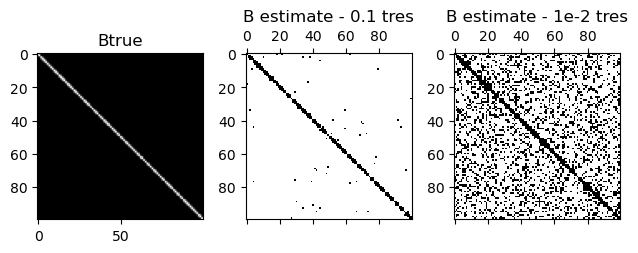

In [1136]:
plt.subplot(1,3, 1)
plt.imshow(B, cmap= "gray")
plt.title("Btrue")
plt.subplot(1,3,2)
# plt.imshow(hard_threshold(B_estimate, 0.2), cmap= "gray")
plt.spy(hard_threshold(B_estimate, 0.2))
plt.title("B estimate - 0.1 tres")
plt.subplot(1,3,3)
# plt.imshow(hard_threshold(B_estimate, 0.4), cmap= "gray")
plt.spy(hard_threshold(B_estimate, 1e-2))
plt.tight_layout()
plt.title("B estimate - 1e-2 tres")

Experimentation

In [1134]:
def evaluate_metrics_vs_lambda(lambda_values, B, sample_scaling = 1.0,  rho=1.0, max_iter=100, tol=1e-4, threshold=1e-4, log_dir="experiment_logs"):    
    """
    Evaluate Frobenius norm, KL divergence, MCC, Sensitivity, and Specificity
    of the estimated precision matrix at various lambda values.
    """
    
    B = np.array(B)
    n = len(B)
    S, N = generate_sparse_covariance(B, sample_scaling= sample_scaling)
    ground_truth_adjacency = (B != 0).astype(int).flatten()
    logdet_B = np.log(np.linalg.det(B))

    print("Number of samples:", N)
    print("Minimum eigenvalue:", np.min(np.linalg.eigvals(B)))

    metrics = {
        "lambda": [],
        "Fnorm": [],
        "KL": [],
        "MCC": [],
        "sensitivity": [],
        "specificity": [],
        "f1": [], 
        "plot_paths": []
    }


    for lambda_ in lambda_values:
        # Compute estimated precision matrix
        B_est  = admm_precision_matrix(S, lambda_, rho, max_iter, tol)
        
        # Apply thresholding
        B_est_thresholded  = hard_threshold(B_est, threshold)

        # Plot sparsity patterns and save them
        plt.figure(figsize=(6, 12))

        plt.subplot(1, 2, 1)
        plt.spy(B)
        plt.title('B matrix', fontsize=16)

        # Placeholder for estimated matrix
        plt.subplot(1, 2, 2)
        plt.spy(B_est_thresholded)
        plt.title('B_hat (Estimated)', fontsize=16)

        plot_path = os.path.join(log_dir, f"sparsity_patterns_lambda_{lambda_:.3f}.png")
        plt.savefig(plot_path)
        plt.close()
        
        metrics["plot_paths"].append(plot_path)

        # Fnorm_val
        Fnorm_val = np.linalg.norm(B - B_est, ord='fro')

        # KL divergence
        try:
            inv_Best = np.linalg.inv(B_est)
            logdet_Best = np.log(np.linalg.det(B_est))
            trace_term = np.trace(inv_Best @ B)
            KL_val = -logdet_Best + trace_term + logdet_B - n
        except np.linalg.LinAlgError:
            # If B_est is singular, define KL as +∞ or some large number
            KL_val = np.inf
        
        predicted_adjacency = (B_est_thresholded != 0).astype(int).flatten()
        cm = confusion_matrix(ground_truth_adjacency, predicted_adjacency, labels=[0,1])
        TN, FP, FN, TP = cm.ravel()

        # MCC = (TP*TN - FP*FN) / sqrt( (TP+FP)*(TP+FN)*(TN+FP)*(TN+FN) )
        # We'll do a safe-check:
        denom = (TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)
        if denom == 0:
            MCC_val = 0.0
        else:
            MCC_val = ((TP*TN) - (FP*FN)) / np.sqrt(denom)
        
        # Sensitivity = TP / (TP + FN)  [recall]
        sensitivity_val = TP / (TP + FN) if (TP+FN) > 0 else 0.0
        # Specificity = TN / (TN + FP)
        specificity_val = TN / (TN + FP) if (TN+FP) > 0 else 0.0
        # F1 score
        f1_val = f1_score(ground_truth_adjacency, predicted_adjacency)

        metrics["lambda"].append(lambda_)
        metrics["Fnorm"].append(Fnorm_val)
        metrics["KL"].append(KL_val)
        metrics["MCC"].append(MCC_val)
        metrics["sensitivity"].append(sensitivity_val)
        metrics["specificity"].append(specificity_val)
        metrics["f1"].append(f1_val)

    return metrics


In [1142]:
# Updated main loop
n = 200
sample_scaling = 2.0
B = make_tridiagonal_spd_matrix(n_dim= n)

log_dir = f"experiment_logs/n_{n}_scale_{sample_scaling}"
# Create a directory to save logs if it doesn’t exist
os.makedirs(log_dir, exist_ok=True)

# params
args = {
    "lambda_values": np.linspace(0.1,2, 30).tolist(),
    "B": B.tolist(),
    "sample_scaling": sample_scaling,
    "rho": 5.0,
    "max_iter": 200,
    "tol": 1e-4,
    "threshold": 2e-1,
    "log_dir": log_dir
}
print(f"Evaluating metrics for {args}")

# Save args to a JSON file (for reproducibility)
json_path = os.path.join(log_dir, "params.json")
with open(json_path, "w") as json_file:
    json.dump(args, json_file, indent=4)

# Call our updated evaluate_metrics_vs_lambda
metrics = evaluate_metrics_vs_lambda(**args)

# Convert metrics to a DataFrame
metrics_df = pd.DataFrame(metrics)

# Save metrics to CSV or Excel
csv_path = os.path.join(log_dir, "metrics.csv")
metrics_df.to_csv(csv_path, index=False)

# Pick best lambda by F1
best_idx = metrics_df["f1"].idxmax()
best_lambda = metrics_df.loc[best_idx, "lambda"]
print(f"Best lambda by F1 = {best_lambda:.3f}")

# Plot all metrics vs. lambda
plt.figure(figsize=(8, 6))
for metric in ["f1"]:
    plt.plot(metrics_df["lambda"], metrics_df[metric], marker="o", label=metric)

plt.xscale("log")
plt.xlabel("Lambda")
plt.ylabel("Metric Value")
plt.title("Metrics vs. Lambda")
plt.legend()
plot_path = os.path.join(log_dir, "metrics_vs_lambda.png")
plt.savefig(plot_path)
plt.close()


Minimum eigenvalue too small (-3.18e-01), adding 0.1 to diagonal elements.
Evaluating metrics for {'lambda_values': [0.1, 0.16551724137931034, 0.23103448275862068, 0.296551724137931, 0.3620689655172413, 0.4275862068965517, 0.49310344827586206, 0.5586206896551723, 0.6241379310344827, 0.689655172413793, 0.7551724137931034, 0.8206896551724137, 0.886206896551724, 0.9517241379310344, 1.0172413793103448, 1.0827586206896551, 1.1482758620689655, 1.2137931034482758, 1.2793103448275862, 1.3448275862068966, 1.410344827586207, 1.475862068965517, 1.5413793103448274, 1.6068965517241378, 1.6724137931034482, 1.7379310344827585, 1.803448275862069, 1.8689655172413793, 1.9344827586206894, 2.0], 'B': [[1.4177129634002286, 0.5896491823621268, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

F1 vs sample scaling

In [1140]:
def plot_f1_vs_sample_scaling(
    B,
    best_lambda=1.2,
    rho=3.0,
    max_iter=500,
    tol=1e-4,
    threshold=2e-2,
    scaling_values=None,
    log_dir="experiment_scale_logs"
):
    """
    Fix parameters (n, alpha, best_lambda, etc.) and update sample_scaling from
    1..20 to see how F1 improves with more samples.
    """
    if scaling_values is None:
        # By default, range from 1 to 20 inclusive
        scaling_values = np.arange(1, 21)

    os.makedirs(log_dir, exist_ok=True)
    n = len(B)

    f1_scores = []
    if B is None:
        B = make_tridiagonal_spd_matrix(n_dim= n)
    
    # S, N = generate_sparse_covariance(
    #         B,
    #         sample_scaling=2.0,
    #     )


    for scale in scaling_values:
        _f1_scores = []
        for i in range(10):
            # Generate data with the current scale
            S, N = generate_sparse_covariance(
                B,
                sample_scaling=scale,
            )

            # Estimate precision matrix using the best param config
            B_est = admm_precision_matrix(S, best_lambda, rho, max_iter, tol)
            
            # Threshold the estimate
            B_est_thresholded = hard_threshold(B_est, threshold)

            # Compute adjacency-based F1
            ground_truth = (B != 0).astype(int).ravel()
            predicted = (B_est_thresholded != 0).astype(int).ravel()
            f1_val = f1_score(ground_truth, predicted, zero_division=0)
            _f1_scores.append(f1_val)

        f1_scores.append(np.average(_f1_scores))

        print(f"scale={scale}, #samples={N}, F1={f1_val:.3f}")

    # Convert to DataFrame for convenience
    df = pd.DataFrame({
        "sample_scaling": scaling_values,
        "F1": f1_scores
    })

    # Save to CSV
    csv_path = os.path.join(log_dir, f"f1_vs_scaling_{n}_threshold_{threshold}.csv")
    df.to_csv(csv_path, index=False)

    # Plot
    plt.figure(figsize=(6, 4))
    plt.plot(scaling_values, f1_scores, marker="o")
    plt.xlabel("Experiment")
    plt.ylabel("F1 Score")
    plt.title(f"F1 vs. Experiment (n={n}, lambda={best_lambda}, threshold={threshold})")
    plt.grid(True)
    plot_path = os.path.join(log_dir, f"f1_vs_scaling_{n}_threshold_{threshold}.png")
    plt.savefig(plot_path)
    plt.close()

    return df

In [1143]:
plot_f1_vs_sample_scaling(
        B,
        best_lambda=0.297,
        rho=5.0,
        max_iter=200,
        tol=1e-4,
        threshold=1e-1,
        scaling_values=np.linspace(1, 5, 10), 
        log_dir="f1_scale_experiment"
    )

Max degree in B 2
Iteration 5, Error: 1.52e-14
Iteration 5, Error: 4.82e-15
Iteration 5, Error: 4.97e-15
Iteration 5, Error: 4.87e-15
Iteration 5, Error: 4.95e-15
Iteration 5, Error: 5.08e-15
Iteration 5, Error: 4.64e-15
Iteration 5, Error: 4.80e-15
Iteration 5, Error: 4.93e-15
Iteration 5, Error: 5.01e-15
Iteration 5, Error: 5.27e-15
ADMM Converged after 171 iterations.
Max degree in B 2
Iteration 5, Error: 6.76e-15
Iteration 5, Error: 5.71e-15
Iteration 5, Error: 6.06e-15
Iteration 5, Error: 5.78e-15
Iteration 5, Error: 5.89e-15
Iteration 5, Error: 5.69e-15
Iteration 5, Error: 6.13e-15
Iteration 5, Error: 5.88e-15
Iteration 5, Error: 6.31e-15
Iteration 5, Error: 5.62e-15
ADMM Converged after 164 iterations.
Max degree in B 2
Iteration 5, Error: 9.07e-15
Iteration 5, Error: 4.58e-15
Iteration 5, Error: 4.89e-15
Iteration 5, Error: 4.43e-15
Iteration 5, Error: 4.94e-15
Iteration 5, Error: 5.07e-15
Iteration 5, Error: 4.67e-15
Iteration 5, Error: 4.75e-15
Iteration 5, Error: 4.57e-15
It

,sample_scaling,F1
0,1.000000,0.374024
1,1.444444,0.503230
2,1.888889,0.664788
3,2.333333,0.774349
4,2.777778,0.841641
5,3.222222,0.876956
6,3.666667,0.893571
7,4.111111,0.899006
8,4.555556,0.907737
9,5.000000,0.907290
